In [2]:
import torch 
import torch.nn as nn 
import torch.optim as optim



In [3]:
import urllib.request
import zipfile
import os

URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip"
ZIP_PATH = "UCI_HAR_Dataset.zip"
EXTRACT_DIR = "data"

if not os.path.exists(ZIP_PATH):
    print("Downloading UCI HAR dataset...")
    urllib.request.urlretrieve(URL, ZIP_PATH)


if not os.path.exists(os.path.join(EXTRACT_DIR, "UCI HAR Dataset")):
    print("Extracting dataset...")
    with zipfile.ZipFile(ZIP_PATH, "r") as zip_ref:
        zip_ref.extractall(EXTRACT_DIR)

print("Done.")


Done.


In [4]:
import numpy as np
import os

BASE = "data/UCI HAR Dataset"

def load_har(split="train"):
    base = os.path.join(BASE, split, "Inertial Signals")
    signals = [
        "body_acc_x", "body_acc_y", "body_acc_z",
        "body_gyro_x", "body_gyro_y", "body_gyro_z",
        "total_acc_x", "total_acc_y", "total_acc_z",
    ]

    X = []
    for s in signals:
        X.append(
            np.loadtxt(os.path.join(base, f"{s}_{split}.txt"))
        )

    X = np.stack(X, axis=-1)              # (N, 128, 9)
    y = np.loadtxt(
        os.path.join(BASE, split, f"y_{split}.txt")
    ) - 1                                 # Labels 0..5

    return X.astype("float32"), y.astype("int32")


In [5]:
X_train, y_train = load_har("train")
X_test,  y_test  = load_har("test")

print(X_train.shape)  # (7352, 128, 9)
print(y_train.shape)  # (7352,)

mean = X_train.mean(axis=(0, 1), keepdims=True)
std  = X_train.std(axis=(0, 1), keepdims=True) + 1e-6

X_train = (X_train - mean) / std
X_test  = (X_test  - mean) / std


(7352, 128, 9)
(7352,)


In [6]:
y_train

array([4, 4, 4, ..., 1, 1, 1], shape=(7352,), dtype=int32)

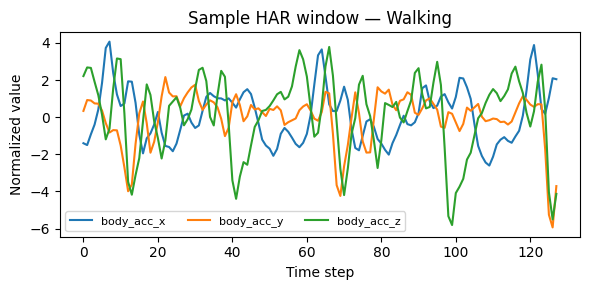

In [7]:
import matplotlib.pyplot as plt

class_names = [
    'Walking',
    'Walking Upstairs',
    'Walking Downstairs',
    'Sitting',
    'Standing',
    'Laying',
]

idx = 5000  # change to view a different sample
t = range(X_train.shape[1])
activity = class_names[int(y_train[idx])]

plt.figure(figsize=(6, 3))
plt.plot(t, X_train[idx, :, 0], label='body_acc_x')
plt.plot(t, X_train[idx, :, 1], label='body_acc_y')
plt.plot(t, X_train[idx, :, 2], label='body_acc_z')
plt.xlabel('Time step')
plt.ylabel('Normalized value')
plt.title(f'Sample HAR window — {activity}')
plt.legend(fontsize=8, ncol=3)
plt.tight_layout()
plt.show()


In [8]:
from torch.utils.data import TensorDataset, DataLoader, random_split

BATCH = 64
device = "mps" # mac -> mps, windows -> cpu 

train_ds_full = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train).long())
test_ds = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test).long())

val_frac = 0.15
val_size = int(len(train_ds_full) * val_frac)
train_size = len(train_ds_full) - val_size
generator = torch.Generator().manual_seed(42)
train_ds, val_ds = random_split(train_ds_full, [train_size, val_size], generator=generator)

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH, shuffle=False)


In [9]:
class hRNN(nn.Module):
    def __init__(self, num_classes=6, input_size=9, n_fc1=64, drop=0.2, hidden_size=64):  # lightweight 1-layer LSTM
        super().__init__()
        # stage 1: single-layer LSTM
        self.rnn = nn.GRU(input_size, hidden_size, bidirectional=True, num_layers=1, batch_first=True)

        # classifier
        self.fc1 = nn.Linear(4*hidden_size, n_fc1)
        self.drop = nn.Dropout(drop)
        self.fc2 = nn.Linear(n_fc1, num_classes)
    
    def forward(self, x):
        out, _ = self.rnn(x)           # (B, T, 2H)
        mean = out.mean(dim=1)
        mx   = out.max(dim=1).values
        feat = torch.cat([mean, mx], dim=1)  # (B, 4H)
        out = torch.relu(self.fc1(feat))
        return self.fc2(out)

model = hRNN(input_size=9, hidden_size=64, n_fc1=256, drop=0.5, num_classes=6).to(device)


In [10]:
loss = nn.CrossEntropyLoss() # because multi-class 
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3) # Adam = modern gradient-based method (roughly speaking)

epochs = 50
patience = 7 # 3-5-7 Patience is the number of consecutive epochs without improvement that we allow before training stops 
# usually improvement means lower validation loss 
# sometimes it is equal to test loss 
# sometimes you split the dataset in (train, val, test) and use val-part for computing validation loss
best_val_loss = float("inf") # 
patience_left = patience 
best_state = None 

for epoch in range(1, epochs+1):
    model.train()

    train_loss = .0
    train_correct = 0
    train_count = 0

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        # training
        optimizer.zero_grad()
        logits = model(xb) # expectation
        loss_out = loss(logits, yb) # expectation - reality 
        loss_out.backward()
        optimizer.step()
    
        batch_size = xb.size(0)
        train_loss += loss_out.item() * batch_size
        train_correct += (logits.argmax(dim=1)==yb).sum().item() # number of correctly classified
        train_count += batch_size

    train_loss /= train_count
    train_acc = train_correct/train_count

    model.eval() # validation data
    val_loss = .0
    val_correct = 0
    val_count = 0

    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb)
            loss_out = loss(logits,yb)
            batch_size = xb.size(0)
            val_loss += loss_out.item() * batch_size
            val_correct += (logits.argmax(dim=1)==yb).sum().item() # number of correctly classified
            val_count += batch_size

    val_loss /= val_count
    val_acc = val_correct/val_count

    print(
        f"Epoch {epoch} | train_loss= {train_loss:.4f} acc= {train_acc:.4f} |"
        f"val_loss= {val_loss:.4f} acc= {val_acc:.4f}"
    )

    if val_loss<best_val_loss - 1e-3:
        best_val_loss = val_loss
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()} # save the weights 
        patience_left = patience
    else:
        patience_left -= 1
        if patience_left == 0:
            print("Early stopping")
            break

if best_state is not None:
    model.load_state_dict(best_state)


Epoch 1 | train_loss= 0.6209 acc= 0.7773 |val_loss= 0.2151 acc= 0.9256
Epoch 2 | train_loss= 0.1544 acc= 0.9464 |val_loss= 0.1183 acc= 0.9465
Epoch 3 | train_loss= 0.1251 acc= 0.9507 |val_loss= 0.1259 acc= 0.9410
Epoch 4 | train_loss= 0.1237 acc= 0.9496 |val_loss= 0.1087 acc= 0.9619
Epoch 5 | train_loss= 0.1118 acc= 0.9549 |val_loss= 0.0980 acc= 0.9537


KeyboardInterrupt: 

In [ ]:
def train_rnn(patience=5):
    loss = nn.CrossEntropyLoss() # because multi-class 
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3) # Adam = modern gradient-based method (roughly speaking)

    epochs = 30
    #patience = 5 # 3-5-7 Patience is the number of consecutive epochs without improvement that we allow before training stops 
    # usually improvement means lower validation loss 
    # sometimes it is equal to test loss 
    # sometimes you split the dataset in (train, val, test) and use val-part for computing validation loss
    best_val_loss = float("inf") # 
    best_acc = 0.0
    patience_left = patience 
    best_state = None 

    for epoch in range(1, epochs+1):
        model.train()

        train_loss = .0
        train_correct = 0
        train_count = 0

        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            # training
            optimizer.zero_grad()
            logits = model(xb) # expectation
            loss_out = loss(logits, yb) # expectation - reality 
            loss_out.backward()
            optimizer.step()
        
            batch_size = xb.size(0)
            train_loss += loss_out.item() * batch_size
            train_correct += (logits.argmax(dim=1)==yb).sum().item() # number of correctly classified
            train_count += batch_size

        train_loss /= train_count
        train_acc = train_correct/train_count

        model.eval() # validation data
        val_loss = .0
        val_correct = 0
        val_count = 0

        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                logits = model(xb)
                loss_out = loss(logits,yb)
                batch_size = xb.size(0)
                val_loss += loss_out.item() * batch_size
                val_correct += (logits.argmax(dim=1)==yb).sum().item() # number of correctly classified
                val_count += batch_size

        val_loss /= val_count
        val_acc = val_correct/val_count

        print(
            f"Epoch {epoch} | train_loss= {train_loss:.4f} acc= {train_acc:.4f} |"
            f"val_loss= {val_loss:.4f} acc= {val_acc:.4f}"
        )

        if val_loss<best_val_loss - 1e-3:
            best_val_loss = val_loss
            best_acc = val_acc
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()} # save the weights 
            patience_left = patience
        else:
            patience_left -= 1
            if patience_left == 0:
                print("Early stopping")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    
    return best_acc


In [ ]:
hidden_size_list = [ 64, 256] # grid search 
drop_list = [0.2, 0.3, 0.4, 0.5]
feat_list = [64, 128, 256]
patience_list = [3, 5, 7]



acc_res = {}
for h in hidden_size_list:
    model = hRNN(input_size=9, hidden_size=h, num_classes=6).to(device)
    acc = train_rnn()
    acc_res[h] = acc

acc_res

Epoch 1 | train_loss= 1.1093 acc= 0.5554 |val_loss= 0.5796 acc= 0.8058
Epoch 2 | train_loss= 0.3634 acc= 0.8845 |val_loss= 0.2024 acc= 0.9310
Epoch 3 | train_loss= 0.1820 acc= 0.9386 |val_loss= 0.1446 acc= 0.9319
Epoch 4 | train_loss= 0.1529 acc= 0.9416 |val_loss= 0.1468 acc= 0.9383
Epoch 5 | train_loss= 0.1988 acc= 0.9250 |val_loss= 0.1867 acc= 0.9356
Epoch 6 | train_loss= 0.1588 acc= 0.9397 |val_loss= 0.1292 acc= 0.9356
Epoch 7 | train_loss= 0.1680 acc= 0.9336 |val_loss= 0.1600 acc= 0.9310
Epoch 8 | train_loss= 0.1438 acc= 0.9459 |val_loss= 0.1291 acc= 0.9537
Epoch 9 | train_loss= 0.1321 acc= 0.9523 |val_loss= 0.1290 acc= 0.9492
Epoch 10 | train_loss= 0.1189 acc= 0.9547 |val_loss= 0.1221 acc= 0.9510
Epoch 11 | train_loss= 0.1123 acc= 0.9549 |val_loss= 0.1161 acc= 0.9528
Epoch 12 | train_loss= 0.1114 acc= 0.9560 |val_loss= 0.1243 acc= 0.9528
Epoch 13 | train_loss= 0.1072 acc= 0.9582 |val_loss= 0.1170 acc= 0.9564
Epoch 14 | train_loss= 0.1091 acc= 0.9566 |val_loss= 0.1133 acc= 0.9564
E

KeyboardInterrupt: 

In [ ]:
import random 

hidden_size_list = [ 128] # random search 
drop_list = [0.2, 0.3, 0.4, 0.5]
feat_list = [64, 128, 256]
patience_list = [3, 5, 7]

n_trials = 5

acc_res = {}
for trial in range(n_trials):
    h = random.choice(hidden_size_list)
    drop = random.choice(drop_list)
    feat = random.choice(feat_list)
    patience = random.choice(patience_list)
    model = hRNN(input_size=9, hidden_size=h, drop=drop, n_fc1=feat, num_classes=6).to(device)
    acc = train_rnn(patience=patience)
    acc_res[(h, drop, feat, patience)] = acc

acc_res

Epoch 1 | train_loss= 0.7424 acc= 0.7231 |val_loss= 0.5644 acc= 0.8073
Epoch 2 | train_loss= 0.3066 acc= 0.8920 |val_loss= 0.3797 acc= 0.8673
Epoch 3 | train_loss= 0.2239 acc= 0.9183 |val_loss= 0.2932 acc= 0.8951
Epoch 4 | train_loss= 0.1817 acc= 0.9328 |val_loss= 0.4041 acc= 0.8816
Epoch 5 | train_loss= 0.1666 acc= 0.9344 |val_loss= 0.3390 acc= 0.8928
Epoch 6 | train_loss= 0.1317 acc= 0.9470 |val_loss= 0.3874 acc= 0.8931
Early stopping
Epoch 1 | train_loss= 0.7094 acc= 0.7326 |val_loss= 0.5717 acc= 0.7964
Epoch 2 | train_loss= 0.2715 acc= 0.9033 |val_loss= 0.3716 acc= 0.8880
Epoch 3 | train_loss= 0.1936 acc= 0.9274 |val_loss= 0.3392 acc= 0.8901
Epoch 4 | train_loss= 0.1658 acc= 0.9370 |val_loss= 0.3114 acc= 0.9063
Epoch 5 | train_loss= 0.1687 acc= 0.9332 |val_loss= 0.2750 acc= 0.9016
Epoch 6 | train_loss= 0.1277 acc= 0.9487 |val_loss= 0.3584 acc= 0.8792
Epoch 7 | train_loss= 0.1353 acc= 0.9437 |val_loss= 0.3126 acc= 0.9165
Epoch 8 | train_loss= 0.1233 acc= 0.9482 |val_loss= 0.2544 acc

{(128, 0.4, 128, 3): 0.8951476077366813,
 (128, 0.3, 128, 3): 0.9049881235154394,
 (128, 0.4, 128, 5): 0.9273837801153716,
 (128, 0.3, 128, 7): 0.9046487953851374,
 (128, 0.5, 256, 7): 0.9229725144214456}

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

model.eval()
all_logits = []

with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        all_logits.append(logits.cpu().numpy())

logits = np.concatenate(all_logits, axis=0)
y_pred = np.argmax(logits, axis=1)

cm = confusion_matrix(y_test, y_pred)
cm


array([[478,  12,   6,   0,   0,   0],
       [  0, 429,  42,   0,   0,   0],
       [  1,   0, 419,   0,   0,   0],
       [  0,   4,   0, 403,  84,   0],
       [  2,   0,   0,  30, 500,   0],
       [  0,   2,   0,   0,   0, 535]])

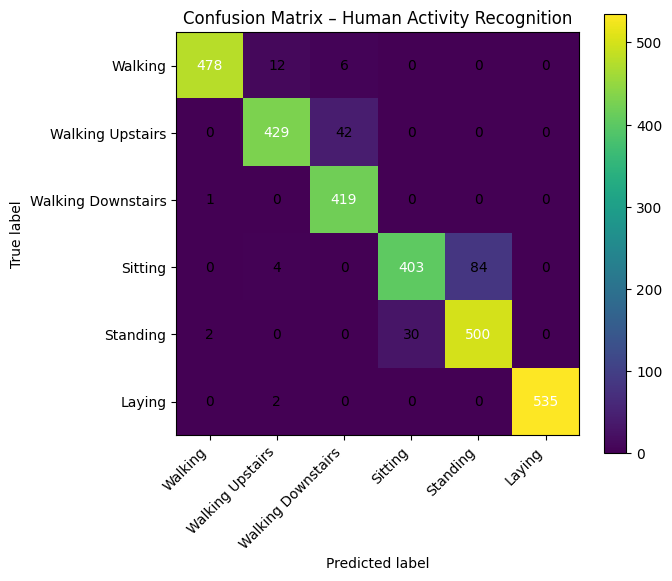

In [ ]:
import matplotlib.pyplot as plt

class_names = [
    "Walking",
    "Walking Upstairs",
    "Walking Downstairs",
    "Sitting",
    "Standing",
    "Laying",
]

fig, ax = plt.subplots(figsize=(7, 6))
im = ax.imshow(cm)

ax.set_xticks(range(len(class_names)))
ax.set_yticks(range(len(class_names)))
ax.set_xticklabels(class_names, rotation=45, ha="right")
ax.set_yticklabels(class_names)

ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title("Confusion Matrix – Human Activity Recognition")

# Werte einzeichnen
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j],
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2 else "black")

fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()
